# Model to predict the number of users

- Here the Bandwidth per source is predicted

In [1]:
import pandas as pd
import pymysql
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
def connect_to_mysql():
    connection = pymysql.connect(host='10.65.47.80',
                            port=4589,
                            user='netsight',
                            password='Enterasys',
                            db='netsightrpt',
                            charset='utf8',
                            cursorclass=pymysql.cursors.DictCursor)
    return connection

conn=connect_to_mysql()

In [3]:
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

def plot_test(x,y,title1):
    #label = data.index[0:len(compare_train)]
    label1=x
    #py.init_notebook_mode
        

    # Create a trace
    
    trace1 = go.Scatter(
        x = label1,
        y = np.array(y),
        name ='Actual',
        mode = 'lines+markers'
    
        )


    # Edit the layout
    layout = dict(title = title1,
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'bandwidth'),
              )
    

    data = [trace1]
    fig = dict(data=data, layout=layout)
    fig =go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='basic-line')
    #py.iplot(fig, filename='jupyter/basic_bar')
  

In [4]:
def plot_test1(x,y,y2,title1):
    #label = data.index[0:len(compare_train)]
    label1=x
    #py.init_notebook_mode
        

    # Create a trace
    
    trace1 = go.Scatter(
        x = label1,
        y = np.array(y),
        name ='Actual',
        mode = 'lines+markers'
    
        )
    
    trace2 = go.Scatter(
        x = label1,
        y = np.array(y2),
        name ='Predicted',
        mode = 'lines+markers'
    
        )



    # Edit the layout
    layout = dict(title = title1,
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'band_width'),
              )
    

    data = [trace1,trace2]
    fig = dict(data=data, layout=layout)
    fig =go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='basic-line')

## 1. Fetching data

In [5]:
with conn.cursor() as cursor:
        # Read a  record
        sql = "select sum(byte_count) as byte_count_sum, time_stamp, source from appid_datapoint group by source, time_stamp" 
        cursor.execute(sql)
        bw_df = pd.DataFrame(cursor.fetchall())

In [6]:
bw_df.to_csv('bw_per_source_dataset.csv',index=False)

In [24]:
bw_df = pd.read_csv("bw_per_source_dataset.csv")

bw_df = bw_df[bw_df.byte_count_sum>0]
bw_df = bw_df.sort_values(by='byte_count_sum')

In [25]:
bw_df['bw'] = bw_df['byte_count_sum']/(8*3600)

dates = bw_df.time_stamp#.astype(int)
dates_outlook =pd.to_datetime(pd.Series(dates),unit='ms')
bw_df.index = dates_outlook
bw_df = bw_df.sort_values(by='time_stamp')
bw_df.index[0:5]


DatetimeIndex(['2017-11-11 00:00:00', '2017-11-11 00:00:00',
               '2017-11-11 00:00:00', '2017-11-11 00:00:00',
               '2017-11-11 01:00:00'],
              dtype='datetime64[ns]', name='time_stamp', freq=None)

In [26]:
bw_df.source.value_counts()

134.141.5.104      1930
134.141.208.230    1910
10.6.1.101         1874
134.141.121.91     1869
134.141.5.102      1708
134.141.115.101    1138
134.141.224.29      406
Name: source, dtype: int64

### Prophet Model

In [63]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as mse
import math
from tqdm import tqdm
#z1.index = z1.date
def create_prophet_m(source_name,z1):
    
    ### --- For realtime pred ---###
    
    full_df = z1.bw.iloc[0:len(z1)]
    full_df = full_df.reset_index()
    full_df.columns = ['ds','y']
    
    
    
    #-- Realtime prediction --##
    #model 
    model_r = Prophet(yearly_seasonality=False,changepoint_prior_scale=.2)
    model_r.fit(full_df)
    future_r = model_r.make_future_dataframe(periods=24,freq='H')
    forecast_r = model_r.predict(future_r)
    forecast_r.index = forecast_r['ds']
    #forecast 
    pred_r = pd.DataFrame(forecast_r['yhat'][len(z1):(len(z1)+24)])
    pred_r=pred_r.reset_index()
    
    #--- remove outliers ---#
    
    #train_end_index=int(0.7*len(data_l_ew_g1.app_rsp_time))
    train_end_index=len(z1.bw)-24
    train_df=z1.bw.iloc[0:train_end_index]
    #train_df= train_df[train_df<cutter]
    
    
    test_df=z1.bw.iloc[train_end_index:len(z1)]
    
    
    
    train_df=train_df.reset_index()
    test_df=test_df.reset_index()
    train_df.columns=['ds','y']
    
    #--- removing outliers in trainset  ---#
    
    q50 = train_df.y.median()
    q100 = train_df.y.quantile(1)
    q75  = train_df.y.quantile(.75)
    print(max(train_df.y))
    if((q100-q50) >= (2*q50)):
        print('ind')
        train_df.loc[train_df.y>=(2*q50),'y'] = None
        
        print(max(train_df.y))
        print((q100-q50),(1.5*q50))
    
    
    test_df.columns=['ds','y']
    
    
    #model 
    model = Prophet(yearly_seasonality=False,changepoint_prior_scale=.2)
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(test_df),freq='H')
    forecast = model.predict(future)
    forecast.index = forecast['ds']
    #forecast 
    pred = pd.DataFrame(forecast['yhat'][train_end_index:len(z1)])
    pred=pred.reset_index()
    pred_df=pd.merge(test_df,pred,on='ds',how='left')
    pred_df.dropna(inplace=True)
    
    df=pd.DataFrame()
    
    if(len(pred_df)>0):
        
        pred_df['error_test']=pred_df.y-pred_df.yhat
    
        
    
        MSE=mse(pred_df.y,pred_df.yhat)
        RMSE=math.sqrt(MSE)
        pred_df['APE']=abs(pred_df.error_test*100/pred_df.y)
        MAPE=pred_df.APE.mean()
        print("App name:",source_name)
        print("MSE  :",MSE)
        print("RMSE :",RMSE)
        print("MAPE :",MAPE)
        #print("RMSE from mean :",mean_RMSE)
        #print("MAPE from mean :",mean_MAPE)
    
        #print(pred_df.head())
        q98=pred_df['APE'].quantile(0.98)
        mape_q98=pred_df['APE'][pred_df.APE<pred_df['APE'].quantile(0.98)].mean()

        df = pd.DataFrame({'length':len(z1),#'predicted_t':[forcast_lag],
                             'test_rmse':RMSE,
                             'test_mape':MAPE,
                 
                 'test_mape_98':mape_q98},
                      #'rmse_by_mean':mean_RMSE,
                      #'mape_by_mean':mean_MAPE}
                          index=[source_name])

    return(df,model,forecast,pred_df,pred_r)

### Examples

#### 1.

In [64]:
s = '10.6.1.101'
bw_df_1s = bw_df[(bw_df.source==s)]
plot_test(bw_df_1s.index,bw_df_1s.bw,s)

In [65]:
ew_prophet,ew_model,ew_forcast,ew_pred_df,pred_r=(create_prophet_m((s),bw_df_1s))

/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



16146456.798680555
ind
6505872.359791666
12891538.839670138 4882376.938515625
App name: 10.6.1.101
MSE  : 3219357861412.5195
RMSE : 1794256.9106492302
MAPE : 34.12623900229718


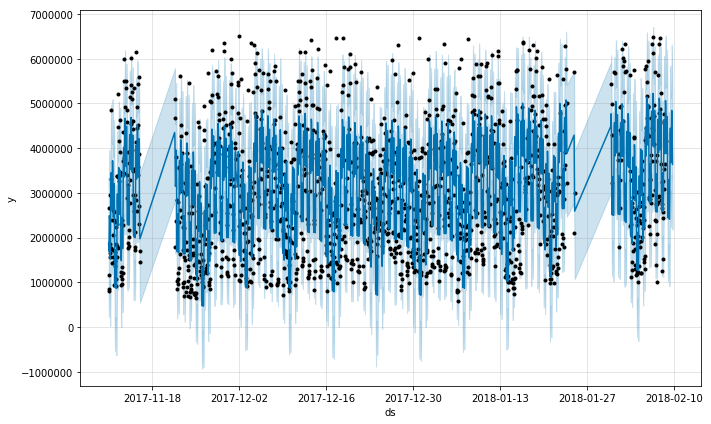

In [66]:
ew_model.plot(ew_forcast)

#### 2.

In [67]:
s = '134.141.121.91'
bw_df_1s = bw_df[(bw_df.source==s)]
plot_test(bw_df_1s.index,bw_df_1s.bw,s)

In [68]:
ew_prophet,ew_model,ew_forcast,ew_pred_df,pred_r=(create_prophet_m((s),bw_df_1s))

/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



3581581.0265625
ind
364188.6382291667
3399436.351388889 273217.01276041666
App name: 134.141.121.91
MSE  : 103619329471.51013
RMSE : 321899.5642611374
MAPE : 61.33483561571046


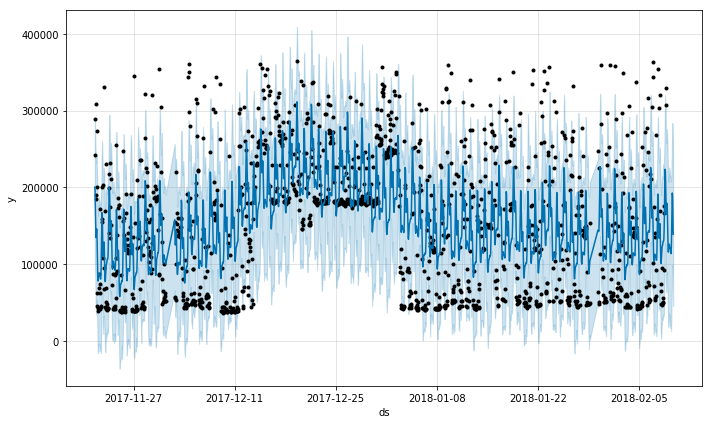

In [69]:
ew_model.plot(ew_forcast)

### For all combinations


In [70]:
s_list = bw_df.source.unique()
prophet_df = pd.DataFrame()
prophet_analysis_df = pd.DataFrame()
prophet_future_df = pd.DataFrame()
temp = bw_df.copy()
for i in tqdm(range(0,len(s_list))):
    s = s_list[i]
    temp2 = temp[temp.source==s]
    
        
    if(len(temp2)<=1400):
        continue
    ew_prophet,ew_model,ew_forcast,ew_pred_df,pred_r=(create_prophet_m(s,temp2))
    
    
    ew_pred_df['source'] = s
    pred_r['source'] = s
        
    ew_prophet['source'] = s
    
    prophet_df = prophet_df.append(ew_pred_df)  
    prophet_analysis_df = prophet_analysis_df.append(ew_prophet)
    prophet_future_df = prophet_future_df.append(pred_r)

  0%|          | 0/7 [00:00<?, ?it/s]/root/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



3428123.2039930555
ind
510218.60559027776
3172853.327864583 382904.81419270835


 14%|█▍        | 1/7 [00:10<01:03, 10.60s/it]

App name: 134.141.208.230
MSE  : 12294703402.778091
RMSE : 110881.48358846076
MAPE : 26.449201196074963
57342824.23565972
ind
30242992.36902778
42210672.285 22698227.925989583


 29%|██▊       | 2/7 [00:20<00:50, 10.15s/it]

App name: 134.141.5.104
MSE  : 9865802650234.195
RMSE : 3140987.5278698886
MAPE : 13.52153832823619
16146456.798680555
ind
6505872.359791666
12891538.839670138 4882376.938515625


 57%|█████▋    | 4/7 [00:29<00:22,  7.35s/it]

App name: 10.6.1.101
MSE  : 3219357861412.5195
RMSE : 1794256.9106492302
MAPE : 34.12623900229718
3581581.0265625
ind
364188.6382291667
3399436.351388889 273217.01276041666


 71%|███████▏  | 5/7 [00:39<00:15,  7.83s/it]

App name: 134.141.121.91
MSE  : 103619329471.51013
RMSE : 321899.5642611374
MAPE : 61.33483561571046
17056668.32888889
ind
3114506.737777778
15498562.0 2337159.493333333


100%|██████████| 7/7 [00:50<00:00,  7.16s/it]

App name: 134.141.5.102
MSE  : 208129619432.29187
RMSE : 456212.2526108783
MAPE : 20.19254509246402


In [71]:
prophet_analysis_df.to_csv('bw_analysis_per_source_data.csv',index=False)
prophet_df.to_csv('bw_evaluation_per_source_data.csv',index=False)
prophet_future_df.to_csv('bw_forecast_per_source_data.csv',index=False)

In [72]:
prophet_analysis_df

,length,test_mape,test_mape_98,test_rmse,source
134.141.208.230,1910,26.449201,25.211900,1.108815e+05,134.141.208.230
134.141.5.104,1930,13.521538,12.813884,3.140988e+06,134.141.5.104
10.6.1.101,1874,34.126239,29.133904,1.794257e+06,10.6.1.101
134.141.121.91,1869,61.334836,57.694421,3.218996e+05,134.141.121.91
134.141.5.102,1708,20.192545,19.257774,4.562123e+05,134.141.5.102


In [4]:
import pandas as pd
my = pd.read_csv('p9/bw_analysis_per_source_data.csv')
my

,length,test_mape,test_mape_98,test_rmse,source
0,1910,26.449201,25.211900,1.108815e+05,134.141.208.230
1,1930,13.521538,12.813884,3.140988e+06,134.141.5.104
2,1874,34.126239,29.133904,1.794257e+06,10.6.1.101
3,1869,61.334836,57.694421,3.218996e+05,134.141.121.91
4,1708,20.192545,19.257774,4.562123e+05,134.141.5.102


### Plots

In [41]:
s='10.6.1.101'
tt = prophet_df[prophet_df.source==s]
plot_test1(tt.ds,tt.y,tt.yhat,s)

In [42]:
s='134.141.208.230'
tt = prophet_df[prophet_df.source==s]
plot_test1(tt.ds,tt.y,tt.yhat,s)

In [43]:
s='134.141.5.104'
tt = prophet_df[prophet_df.source==s]
plot_test1(tt.ds,tt.y,tt.yhat,s)

In [44]:
s='134.141.121.91'
tt = prophet_df[prophet_df.source==s]
plot_test1(tt.ds,tt.y,tt.yhat,s)

In [45]:
s='134.141.5.102'
tt = prophet_df[prophet_df.source==s]
plot_test1(tt.ds,tt.y,tt.yhat,s)

### Parallel processing

In [ ]:
from joblib import Parallel, delayed


def forsource(s,temp):
    
    temp2 = temp[temp.source==s]
        
    if(len(temp2)>1400):
        
        prophet_analysis_df,p_model,p_forcast,prophet_df,prophet_future_df=(create_prophet_m(s,temp2))
    
        prophet_future_df['source']=s
    
        prophet_analysis_df['source'] = s
        
        prophet_df['source'] = s
        #prophet_df.to_csv('parallel_test/eval_'+s+'.csv')
        #prophet_analysis_df.to_csv('parallel_test/analysis_'+s+'.csv')
        #prophet_future_df.to_csv('parallel_test/forecast_'+s+'.csv')
    
    return  prophet_df, prophet_analysis_df, prophet_future_df
        

In [ ]:
s_list = bw_df.source.unique()

pool = Parallel(n_jobs=-1,verbose=5,pre_dispatch='all')
r0  = pool(delayed(forsource)(s,bw_df) for s in s_list)

In [ ]:
prophet_df = pd.DataFrame()
prophet_future_df = pd.DataFrame()
prophet_analysis_df = pd.DataFrame()
for i in range(0,len(r0)):
    prophet_df = prophet_df.append(r0[i][0])
    prophet_analysis_df = prophet_analysis_df.append(r0[i][1])
    prophet_future_df = prophet_future_df.append(r0[i][2])